In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
#import tensorflow_probability as tfp
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-04-24 16:34:06.475070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 16:34:07.019046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64::/home/joel/anaconda3/lib/
2023-04-24 16:34:07.019560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/

# Fitting differential operator

In [3]:
def augment(yx, crop=256, do_flips=True, do_rotate=True, do_scale=True):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 

    ch, cw = yx[0].shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.rand()*360*float(do_rotate),
                            1+float(do_scale)*(np.random.uniform(-0.2,0.2)))
    for i in range(len(yx)):
        yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    return yx
    
N_REPEAT_FRAME = 1

def sample_images(frame_nums):
    while True:
        try:
            var = np.random.uniform(var_d,var_u)
            img = open_frame(np.random.choice(frame_nums),var,CROP)
        except Exception as e:
            print(f'Exception {e} on file')
            continue        
            
        for n in range(N_REPEAT_FRAME):
            
            a =  augment(np.copy(img),crop = CROP)
            yield a
            
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            
            x,y = yx[1],yx[0]
            y = np.expand_dims(y,axis=-1)
            x = np.copy(y)
            y = tf.image.image_gradients(tf.constant(np.array([y])))
            y = (y[0]**2 + y[1]**2)[0]
            
            yield x,y
                    
    return get_data

test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

In [6]:
BATCH_SIZE = 10
var_d=0
var_u=0

dg_train = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(train)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

dg_val = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(test)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

gen_batch_train = dg_train.batch(BATCH_SIZE)
gen_batch_val = dg_val.batch(BATCH_SIZE)

In [7]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

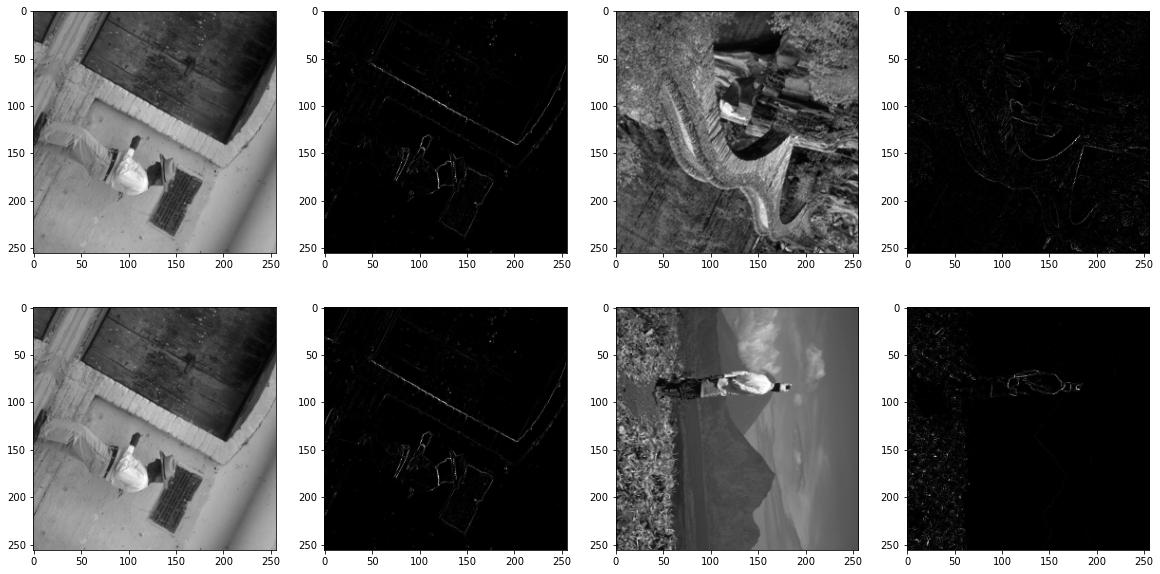

In [8]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        
plt.show()

In [312]:
factor1 = 1
degree = 1
num_filters = np.sum(2**np.arange(1,degree+1))

def constraint(W):
    or_shape = W.shape
    shift = (2*degree+2)*((2*degree+1)//2)
    NW = []
    for w in tf.unstack(W,axis=-1):
        nw = tf.roll(tf.reshape(w,[(2*degree+1)**2]),shift=shift+1,axis=0)
        nw = tf.slice(nw,[1],[(2*degree+1)**2-1])
        nw = tf.abs(nw)
        center = -tf.expand_dims(tf.reduce_sum(nw),0)
        nw = tf.concat((center,nw),axis=0)
        nw = tf.roll(nw,shift,axis=0)
        nw = tf.reshape(nw,(2*degree+1,2*degree+1,1))
        NW.append(nw)
        
    NW = tf.stack(NW,axis=-1)
        
    #return NW/tf.reduce_max(tf.abs(NW),axis=(0,1,2))
    return NW

def regularizer(w):

    w1 = tf.abs(w[::-1,...])
    w = tf.abs(w) + w1 + tf.abs(w[:,::-1,...]) + w1[:,::-1]
    projections = tf.unstack(w,axis=-1)
    initial = 0

    for pr in range(len(projections)):
        for ps in range(len(projections)):
            if pr > ps:
                proj = tf.multiply(projections[pr],projections[ps])
                initial += tf.reduce_sum(tf.abs(proj)) - tf.reduce_sum(tf.abs(proj[degree,degree]))
                
                
    auto = tf.multiply(w,w1) - tf.multiply(w1,w1)
    initial += tf.reduce_sum(tf.math.log(1+auto))
    
    initial += (100)*tf.abs(1-tf.reduce_max(w1))
    
    return factor1 * initial


input_shape = image_size + (1,)
inputs = tf.keras.Input(shape=input_shape,name='input')

x = tf.keras.layers.Conv2D(num_filters,(2*degree+1,2*degree+1),padding='same',use_bias=False,
                        kernel_constraint=constraint,kernel_regularizer = regularizer, name='diff')(inputs)
diff_op1 = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(x)
diff_op = tf.keras.layers.Conv2D(1,1,padding='same',use_bias=False,kernel_initializer='ones',
                                name='no_train')(diff_op1)
diff_op.trainable = False

model = tf.keras.models.Model(inputs, diff_op)
model.layers[-1].trainble = False
model.summary()

Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 1)]     0         
                                                                 
 diff (Conv2D)               (None, 256, 256, 2)       18        
                                                                 
 lambda_85 (Lambda)          (None, 256, 256, 2)       0         
                                                                 
 no_train (Conv2D)           (None, 256, 256, 1)       2         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [313]:
def loss(y_true,y_pred):
    return tf.reduce_mean(tf.multiply(tf.exp(y_true)-1,tf.pow(y_true-y_pred,2)))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=True,
)
)
history = model.fit(
            gen_batch_train,
            epochs=20,
            steps_per_epoch=100,
            validation_data=gen_batch_val,
            validation_steps=10,
            shuffle=False,
            callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5)],
            use_multiprocessing=True,
            workers=1
        )

Epoch 1/20
100/100 [==============================] - 11s 100ms/step - loss: 42.0646 - val_loss: 13.1051 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - 10s 100ms/step - loss: 18.3678 - val_loss: 34.9016 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - 10s 100ms/step - loss: 41.7892 - val_loss: 46.4703 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - 10s 96ms/step - loss: 50.2512 - val_loss: 53.9236 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - 9s 94ms/step - loss: 56.9259 - val_loss: 59.7778 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - ETA: 0s - loss: 61.9735
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
100/100 [==============================] - 9s 95ms/step - loss: 61.9735 - val_loss: 64.0439 - lr: 0.0010
Epoch 7/20
100/100 [==============================] - 9s 94ms/step - loss: 64.4421 - val_loss: 64.8493 - lr: 2.0000e-04
Epoch 8/20
100/100 [=============

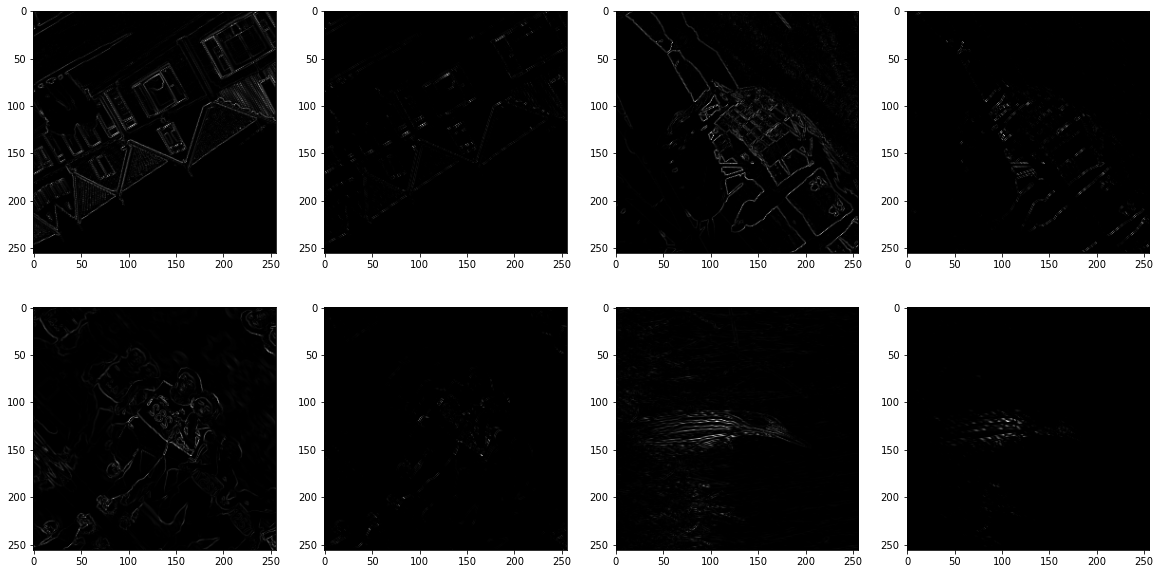

In [314]:
xs, ys = next(gen_batch_val.as_numpy_iterator())
p = model(ys)

nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(ys[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(p[_]),cmap='gray')
        
plt.show()

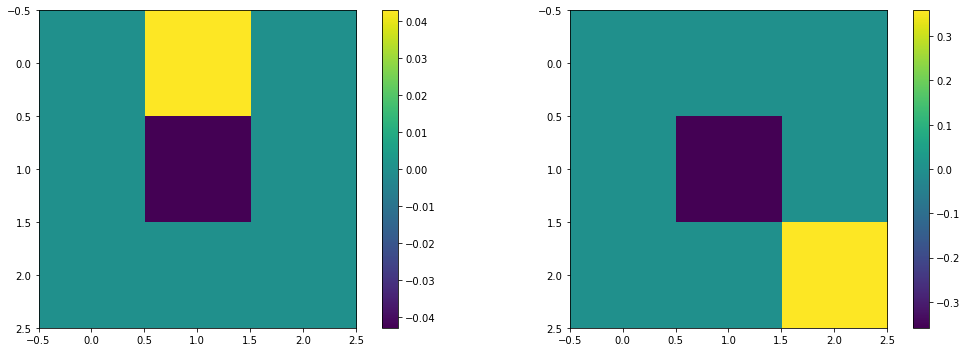

In [318]:
w = np.squeeze(model.layers[1].weights[0].numpy())

fig,axs = plt.subplots(ncols=2,figsize=(15,5))
for i in range(w.shape[-1]):
    im = axs[i].imshow(w[...,i])
    plt.colorbar(im,ax=axs[i])
    
plt.tight_layout()
plt.show()